# Demonstration of Multi-Arm Bandit using the Agent Framework

In [1]:
import nxsdk.api.n2a as nx
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from banditAgent import Bandit
from utils import *

First we will start off by selecting the true parameters of reward for each arm following a Bernoulli distribution (rewards of 1 or 0, with the parameter being probability of a 1).

In [3]:
#seed RNG for consistency
rs = RandomState(378902)

In [4]:
n_actions = 5
epsilon = 0.10

In [5]:
probabilities = get_rewards(rs, n_actions, 50, 60, 10)
optimal_arm = np.argmax(probabilities)

In [143]:
plotargs = {"figsize": (8,6), "dpi" : 100}

Text(0,0.5,'Probability of Reward')

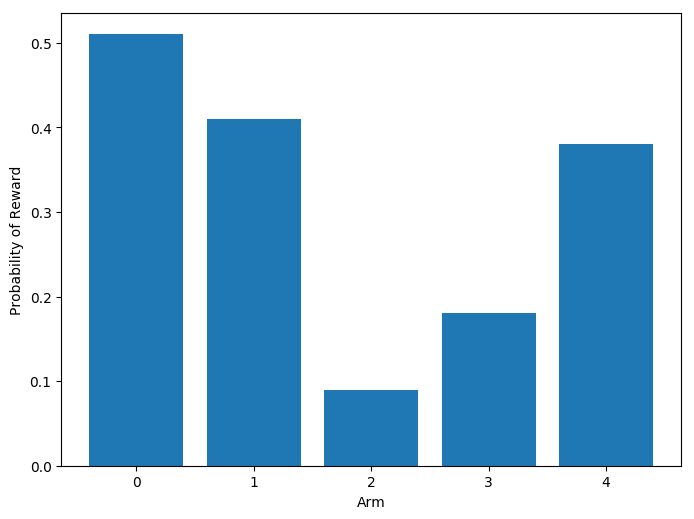

In [145]:
plt.figure(**plotargs)
plt.bar(np.arange(0,n_actions), probabilities)
plt.xlabel("Arm")
plt.ylabel("Probability of Reward")

Now, we set the parameters for the spiking agent. It will sample for 2000 epochs, with a period of 128 cycles for each to estimate the best arm

In [9]:
l_epoch = 128
episodes = 2000
runs = 1

In [11]:
#create the bandit using these settings
bandit = Bandit(probabilities, l_epoch = l_epoch, n_replicates = 2, n_epochs = episodes)

In [12]:
#set a probe to record the spikes from its continuous estimations of value
ctx_spks = bandit.cortex.get_outputs().probe(nx.ProbeParameter.SPIKE)

In [13]:
#run the bandit and disconnect once done
results = []
for i in range(runs):
    results.append(bandit.run())
bandit.board.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:42417
INFO:DRV:      Host server up..............Done 0.43s
INFO:DRV:      Encoding axons/synapses.....Done 0.04s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607979760.8204968
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607979760.8204968/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607979760.8204968/initnetwork_0_0.c.o -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/

In [86]:
actions, rewards, estimates = results[0]

We can look at the actions the agent takes and see that it converges onto the optimal arm with some occasional oscillations away as it continues to sample.

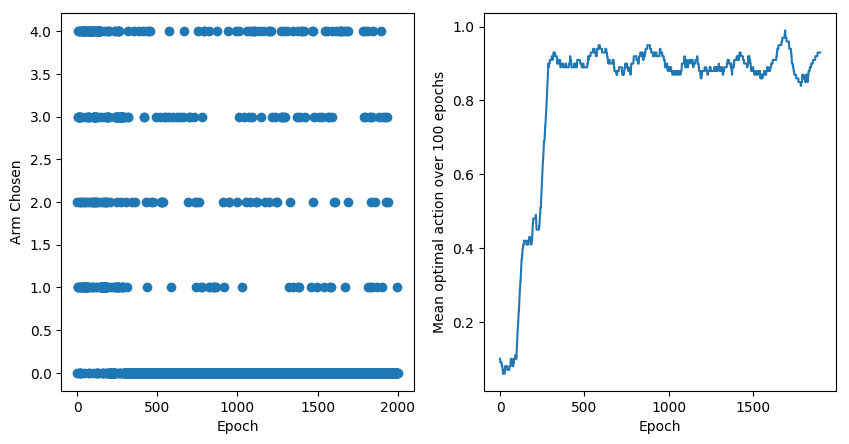

In [155]:
plot_choices(actions, probabilities, figsize=(10,5), dpi=100)

Average reward increases over time as it almost always samples the highest and second-highest arms.

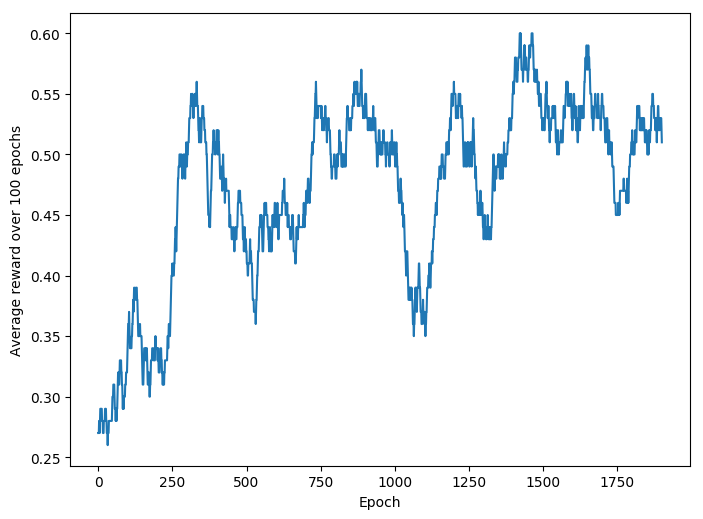

In [156]:
plot_avg_reward(rewards, **plotargs)

Directly looking at the spike counters which estimate the value of each arm, we can observe the relationship between high firing at the encoder output and the corresponding action being chosen. 

Text(0.5,1,'Estimate of value for each a over time')

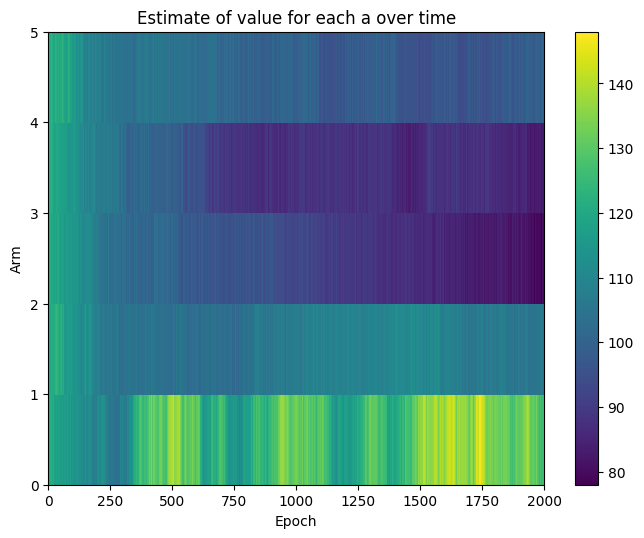

In [157]:
plt.figure(**plotargs)
plt.pcolor(estimates.transpose())
plt.colorbar()
plt.xlabel("Epoch")
plt.ylabel("Arm")
plt.title("Estimate of value for each a over time")

In this case, the encoder is counting spikes from multiple sources in the cortex; above, we define n_replicates in the bandit as 2, and this means 2 tracker nodes are being used for each state to provide a quicker estimate of value each epoch.

In [18]:
unwrap = lambda x: x[0].data

Text(0.5,1,'MFR of All Estimate Neurons over Time')

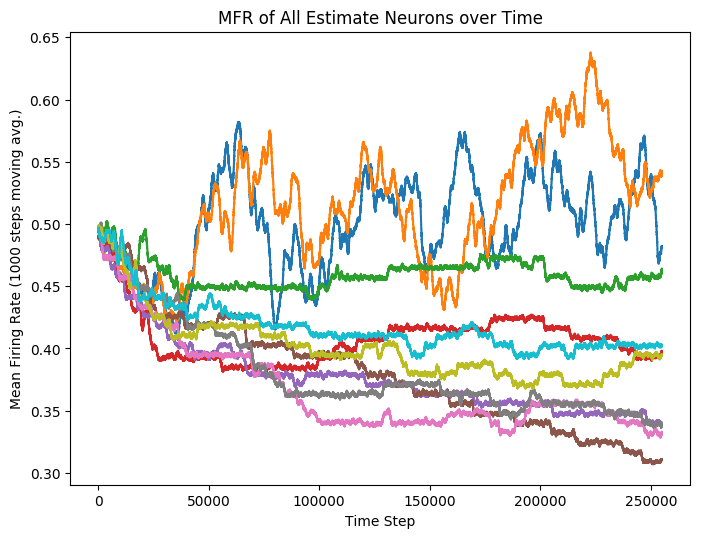

In [158]:
plt.figure(**plotargs)
for i in range(10):
    plt.plot(np.convolve(unwrap(ctx_spks)[i,:], np.ones(1000), mode='valid')/1000)
    
plt.xlabel("Time Step")
plt.ylabel("Mean Firing Rate (1000 steps moving avg.)")
plt.title("MFR of All Estimate Neurons over Time")

The two lines in blue and orange above indicate that the two trackers for the highest arm increase their firing rate as they are sampled and found to be above the rest. Finally, we can do a comparison between the RC-DML and CPU approaches.

In [21]:
import random

In [36]:
probabilities

array([0.51, 0.41, 0.09, 0.18, 0.38])

In [57]:
def egreedy(epochs, epsilon, alpha, probs):
    n_arms = len(probs)
    q = np.ones(n_arms) * 0.5
    choice = -1
    
    estimates = np.ones((epochs, n_arms)) 
    choices = np.zeros(epochs)
    rewards = np.zeros(epochs)
    
    for i in range(epochs):
        if random.random() < epsilon:
            #choose randomly
            choice = random.choice(range(n_arms))
        else:
            #choose highest, breaking ties randomly
            maxima = np.argwhere(q == np.amax(q))
            choice = random.choice(maxima)
            
        #sample the reward for the chosen arm
        if random.random() < probs[choice]:
            reward = 1
        else:
            reward = 0
            
        q[choice] = q[choice] + alpha*(reward - q[choice])
        
        choices[i] = choice
        rewards[i] = reward
        estimates[i,:] = q
    
    return (choices, rewards, estimates)

In [64]:
cpu_action, cpu_reward, cpu_estimate = egreedy(episodes, epsilon, 0.01, probabilities)

In [72]:
avgmoa(cpu_action, probabilities)

0.885

In [90]:
np.mean(rewards == 1)

0.468

In [92]:
np.mean(cpu_reward)

0.5025

In [84]:
np.mean(cpu_reward)

0.5025

In [74]:
avgmoa(actions, probabilities)

0.803

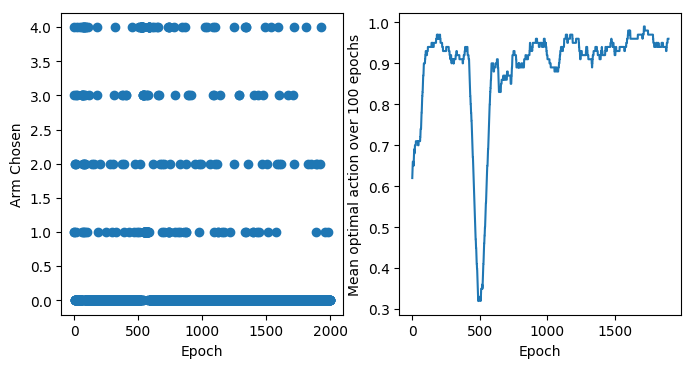

In [76]:
plot_choices(cpu_action, probabilities)

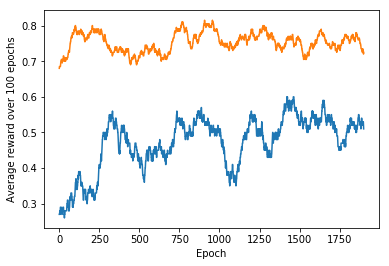

In [71]:
plot_avg_reward(rewards)
plot_avg_reward(cpu_reward)

Individual runs can vary widely due to initial conditions, so we make a comparison across multiple runs.

In [77]:
epsilons = [0.01, 0.05, 0.10, 0.15]


In [135]:
def run_trials(probabilities, epsilons, trials=5, episodes=1000):
    n_epsilons = len(epsilons)

    results = {}
    makearr = lambda: np.zeros((n_epsilons, trials))
    loihi_moa = makearr()
    loihi_rwd = makearr()
    
    cpu_moa = makearr()
    cpu_rwd = makearr()
    
    INTMAX = np.iinfo(np.int32).max
    
    for (i, epsilon) in enumerate(epsilons):
        for t in range(trials):
            #run the Loihi trial with a new seed
            seed = np.random.randint(INTMAX)
            bandit = Bandit(probabilities, epsilon=epsilon, l_epoch = l_epoch, n_replicates = 2, n_epochs = episodes, seed=seed)
            actions, rewards, _ = bandit.run()
            bandit.board.disconnect()
            
            loihi_moa[i,t] = avgmoa(actions, probabilities)
            #remap loihi (-1, 1) rewards to (0,1) before averaging
            loihi_rwd[i,t] = np.mean(rewards == 1)
            
            #run the CPU bandit, seed automatically advances
            actions, rewards, _ = egreedy(episodes, epsilon, 0.01, probabilities)
            cpu_moa[i,t] = avgmoa(actions, probabilities)
            cpu_rwd[i,t] = np.mean(rewards)
            
    results['loihi_moa'] = loihi_moa
    results['loihi_rwd'] = loihi_rwd
    results['cpu_moa'] = cpu_moa
    results['cpu_rwd'] = cpu_rwd
    
    return results
            

In [136]:
test = run_trials(probabilities, epsilons, 5, 6400)

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:44045
INFO:DRV:      Host server up..............Done 0.46s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985229.2601743
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985229.2601743/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985229.2601743/initnetwork_0_0.c.o -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/

INFO:DRV:      Compiling Embedded snips....Done 0.77s
INFO:DRV:      Compiling MPDS Registers....Done 3.29ms
INFO:DRV:      Booting up..................Done 2.09s
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985236.6343422/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Encoding probes.............Done 1.18ms
INFO:DRV:      Transferring probes.........Done 3.72ms
INFO:DRV:      Configuring registers.......Done 0.01s
INFO:DRV:      Transferring spikes.........Done 1.32ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 2.33s
INFO:DRV:      Processing timeseries.......Done 0.79ms
INFO:DRV:  Executor: 819200 timest

INFO:DRV:      Processing timeseries.......Done 0.80ms
INFO:DRV:  Executor: 819200 timesteps......Done 2.38s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:41179
INFO:DRV:      Host server up..............Done 0.29s
INFO:DRV:      Encoding axons/synapses.....Done 0.04s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985250.7668798
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985250.7668798/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.93s
INFO:DRV:      Compiling MPDS Registers....Done 0.87ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985258.1369157/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 3.27ms
INFO:DRV:      Transferring probes.........Done 2.92ms
INFO:DRV:      Configuring registers.......Done 0.02s
INFO:DRV:      Transferring spikes.........Done 1.22ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 2.34s
INFO:DRV:      Processing timeseries.......Done 1.23ms
INFO:DRV:  Executor: 819200 timest

INFO:DRV:      Processing timeseries.......Done 0.89ms
INFO:DRV:  Executor: 819200 timesteps......Done 2.37s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:33085
INFO:DRV:      Host server up..............Done 0.31s
INFO:DRV:      Encoding axons/synapses.....Done 0.04s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985273.0447521
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985273.0447521/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.77s
INFO:DRV:      Compiling MPDS Registers....Done 1.21ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985280.2776005/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 5.80ms
INFO:DRV:      Transferring probes.........Done 5.36ms
INFO:DRV:      Configuring registers.......Done 0.02s
INFO:DRV:      Transferring spikes.........Done 1.21ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 2.34s
INFO:DRV:      Processing timeseries.......Done 0.81ms
INFO:DRV:  Executor: 819200 timest

INFO:DRV:      Processing timeseries.......Done 1.51ms
INFO:DRV:  Executor: 819200 timesteps......Done 2.38s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:45951
INFO:DRV:      Host server up..............Done 0.33s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985294.3944614
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985294.3944614/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 1.00s
INFO:DRV:      Compiling MPDS Registers....Done 0.86ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985301.8469927/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Encoding probes.............Done 4.87ms
INFO:DRV:      Transferring probes.........Done 3.07ms
INFO:DRV:      Configuring registers.......Done 0.03s
INFO:DRV:      Transferring spikes.........Done 3.98ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 2.31s
INFO:DRV:      Processing timeseries.......Done 0.81ms
INFO:DRV:  Executor: 819200 timest

INFO:DRV:      Processing timeseries.......Done 0.85ms
INFO:DRV:  Executor: 819200 timesteps......Done 2.36s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:37013
INFO:DRV:      Host server up..............Done 0.27s
INFO:DRV:      Encoding axons/synapses.....Done 0.04s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985316.3043978
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985316.3043978/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.91s
INFO:DRV:      Compiling MPDS Registers....Done 4.06ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985323.2766895/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.08s
INFO:HST:  Lakemont_driver...
INFO:DRV:      Encoding probes.............Done 1.34ms
INFO:DRV:      Transferring probes.........Done 5.53ms
INFO:DRV:      Configuring registers.......Done 0.03s
INFO:DRV:      Transferring spikes.........Done 5.60ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 2.32s
INFO:DRV:      Processing timeseries.......Done 0.86ms
INFO:DRV:  Executor: 819200 timest

INFO:DRV:      Processing timeseries.......Done 0.86ms
INFO:DRV:  Executor: 819200 timesteps......Done 2.37s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:44159
INFO:DRV:      Host server up..............Done 0.30s
INFO:DRV:      Encoding axons/synapses.....Done 0.04s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985337.8665323
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985337.8665323/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.98s
INFO:DRV:      Compiling MPDS Registers....Done 3.22ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985345.1155841/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.08s
INFO:DRV:      Encoding probes.............Done 4.73ms
INFO:DRV:      Transferring probes.........Done 2.99ms
INFO:DRV:      Configuring registers.......Done 8.00ms
INFO:DRV:      Transferring spikes.........Done 1.55ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 2.31s
INFO:DRV:      Processing timeseries.......Done 1.25ms
INFO:DRV:  Executor: 819200 times

INFO:DRV:      Processing timeseries.......Done 1.18ms
INFO:DRV:  Executor: 819200 timesteps......Done 2.37s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:38535
INFO:DRV:      Host server up..............Done 0.34s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
Compiling in directory : /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985359.4371157
Include dir is : /homes/wolin/reinforcement_learning/bandit
Compiling -c /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985359.4371157/initnetwork_0_0.c
gcc -Wall -I/homes/wolin/reinforcement_learning/bandit -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsd

INFO:DRV:      Compiling Embedded snips....Done 0.89s
INFO:DRV:      Compiling MPDS Registers....Done 0.82ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1607985366.3194642/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.08s
INFO:DRV:      Encoding probes.............Done 0.75ms
INFO:DRV:      Transferring probes.........Done 3.37ms
INFO:DRV:      Configuring registers.......Done 0.03s
INFO:DRV:      Transferring spikes.........Done 1.22ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
INFO:DRV:      Executing...................Done 2.32s
INFO:DRV:      Processing timeseries.......Done 1.82ms
INFO:DRV:  Executor: 819200 timest

In [137]:
test

{'cpu_moa': array([[0.964375  , 0.96078125, 0.949375  , 0.93640625, 0.95      ],
        [0.9178125 , 0.92796875, 0.92390625, 0.874375  , 0.84078125],
        [0.901875  , 0.8753125 , 0.8628125 , 0.89296875, 0.8521875 ],
        [0.79921875, 0.8421875 , 0.80765625, 0.779375  , 0.8675    ]]),
 'cpu_rwd': array([[0.5040625 , 0.5034375 , 0.49515625, 0.51609375, 0.49890625],
        [0.49140625, 0.48765625, 0.4928125 , 0.48921875, 0.48125   ],
        [0.49265625, 0.49375   , 0.4853125 , 0.4896875 , 0.48625   ],
        [0.4671875 , 0.47046875, 0.46890625, 0.4675    , 0.47359375]]),
 'loihi_moa': array([[0.9028125 , 0.789375  , 0.8871875 , 0.939375  , 0.88515625],
        [0.90828125, 0.81359375, 0.8690625 , 0.89328125, 0.85921875],
        [0.86546875, 0.731875  , 0.893125  , 0.81375   , 0.76390625],
        [0.8409375 , 0.8290625 , 0.8571875 , 0.811875  , 0.7928125 ]]),
 'loihi_rwd': array([[0.48390625, 0.481875  , 0.47984375, 0.50953125, 0.49      ],
        [0.489375  , 0.47875   , 0.4

In [111]:
avg = lambda x: np.mean(x, axis=1)

In [117]:
std = lambda x: np.std(x, axis=1)

In [112]:
avg(test['cpu_moa'])

array([0.89696875, 0.909375  , 0.85715625, 0.8563125 ])

Text(0,0.5,'Mean Optimal Action (6400 Epochs)')

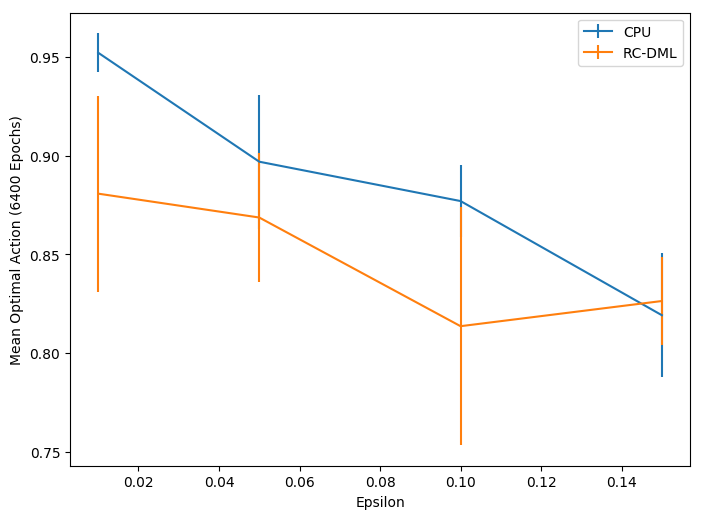

In [140]:
plt.figure(figsize=(8,6),dpi=100)
plt.errorbar(epsilons, avg(test['cpu_moa']), std(test['cpu_moa']), label="CPU")
plt.errorbar(epsilons, avg(test['loihi_moa']), std(test['loihi_moa']), label="RC-DML")
plt.legend()
plt.xlabel("Epsilon")
plt.ylabel("Mean Optimal Action (6400 Epochs)")

Text(0,0.5,'Mean Reward (6400 Epochs)')

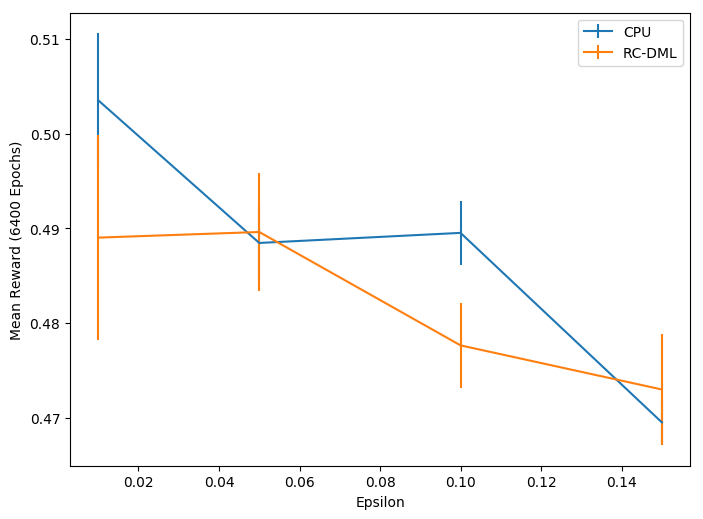

In [141]:
plt.figure(figsize=(8,6),dpi=100)
plt.errorbar(epsilons, avg(test['cpu_rwd']), std(test['cpu_rwd']), label="CPU")
plt.errorbar(epsilons, avg(test['loihi_rwd']), std(test['loihi_rwd']), label="RC-DML")
plt.legend()
plt.xlabel("Epsilon")
plt.ylabel("Mean Reward (6400 Epochs)")